In [1]:
%reload_ext watermark
%reload_ext autoreload
%autoreload 2
%watermark -v -p numpy,sklearn,pandas
%watermark -v -p cv2,PIL,matplotlib
%watermark -v -p torch,torchvision,torchaudio,pytorch_lightning
%matplotlib inline
%config InlineBackend.figure_format='retina'
%config IPCompleter.use_jedi = False


from IPython.display import display, HTML, Javascript
display(HTML('<style>.container { width:%d%% !important; }</style>' % 90))

def _IMPORT_(x):
    try:
        exec(x, globals())
    except:
        pass

CPython 3.6.9
IPython 7.16.1

numpy 1.19.4
sklearn 0.24.0
pandas 1.1.5
CPython 3.6.9
IPython 7.16.1

cv2 4.5.1
PIL 6.2.2
matplotlib 3.3.3
CPython 3.6.9
IPython 7.16.1

torch 1.8.0.dev20210103+cu101
torchvision 0.9.0.dev20210103+cu101
torchaudio not installed
pytorch_lightning 1.2.0


## Import Module

In [2]:
###
### Common ###
###

import os, io, time, math, base64
import subprocess, json

_IMPORT_('import numpy as np')
_IMPORT_('import pandas as pd')
_IMPORT_('from tqdm.notebook import tqdm')

In [3]:
###
### Torch ###
###
_IMPORT_('import torch')
_IMPORT_('import torch.nn as nn')
_IMPORT_('import torch.optim as O')
_IMPORT_('import torch.nn.functional as F')
_IMPORT_('from torchvision import models as M')
_IMPORT_('from torchvision import transforms as T')
_IMPORT_('from torch.utils.data import Dataset, DataLoader')

In [4]:
###
### Viz Model ###
###

_IMPORT_('import hiddenlayer as hl')
_IMPORT_('from graphviz import Digraph, Source')
_IMPORT_('from torchviz import make_dot')
_IMPORT_('from torchsummary import summary')


###
### Display ###
###

_IMPORT_('import cv2')
_IMPORT_('from PIL import Image')
_IMPORT_('from torchvision.utils import make_grid')
_IMPORT_('import matplotlib.pyplot as plt')
_IMPORT_('import plotly.graph_objects as go')


def show_video(video_path, width=None, height=None):
    W, H = '', ''
    if width:
        W = 'width=%d' % width
    if height:
        H = 'height=%d' % height
    mp4 = open(video_path, 'rb').read()
    data_url = 'data:video/mp4;base64,' + base64.b64encode(mp4).decode()
    return HTML('<video %s %s controls src="%s" type="video/mp4"/>' % (W, H, data_url))

def show_image(image_path, width=None, height=None):
    W, H = '', ''
    if width:
        W = 'width=%d' % width
    if height:
        H = 'height=%d' % height
    img = open(image_path, 'rb').read()
    data_url = 'data:image/jpg;base64,' + base64.b64encode(img).decode()
    return HTML('<img %s %s src="%s"/>' % (W, H, data_url))


In [5]:
FRAME_WIDTH, FRAME_HEIGHT = 112, 112
NUM_FRAMES = 64
NUM_DMODEL = 512
REP_OUT_TIME_RATE = 0.12
DATASET_PREFIX = '/data/datasets/cv/countix'

## Install Depends Libraries

In [ ]:
!apt install ffmpeg
!pip3 install youtube_dl

In [6]:
!pip3 install plotly

You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.


## Data Process

### Countix Dataset Download and Crop

```
    vs           cs                ce            ve
    |             |0.5           0.5|             |
    |-------|---------|---------|------|----------|
            |         |         |      |            
            ks       rs        re      ke
    
vs: the video start
ve: the video end
ks: the kinetics start
ke: the kinetics end
rs: repetition start
re: repetition end
cs: clip video start
ce: clip video end 

```

In [ ]:
import youtube_dl

YOUTUBE_PREFIX = 'https://www.youtube.com/watch?v='

SOCKS5_PROXY = 'socks5://127.0.0.1:1881'

YDL_OPTS = {
    'format': 'mp4',
    'proxy': SOCKS5_PROXY,
    'quiet': True,
    'max_filesize': 30000000, # 30MB
}

def video_download_crop(vid, fps, wh, ss, to, raw_dir, out_dir, force=False):
    raw_file = f'{raw_dir}/{vid}.mp4'
    out_file = '%s/%s_%010.6f_%010.6f.mp4' % (out_dir, vid, ss, to)

    if os.path.exists(out_file):
        if force:
            os.remove(out_file)
        return out_file

    if not os.path.exists(raw_file):
        YDL_OPTS['outtmpl'] = raw_file
        with youtube_dl.YoutubeDL(YDL_OPTS) as ydl:
            ydl.download([f'{YOUTUBE_PREFIX}{vid}'])

    if os.path.exists(raw_file):
        cmd = 'ffmpeg -i %s -v 0 -r %f -s %s -ss %s -to %s -an %s' % (
                raw_file, fps, wh, ss, to, out_file)
        subprocess.call(cmd, shell=True)
        return out_file

    return None

def data_preprocess(data_prefix, phase, force=False):
    df = pd.read_csv(f'{data_prefix}/countix_{phase}.csv')
    raw_dir = f'{data_prefix}/raw/{phase}'
    out_dir = f'{data_prefix}/{phase}'
    os.makedirs(raw_dir, exist_ok=True)
    os.makedirs(out_dir, exist_ok=True)
    df['file_name'] = None
    df['rep_start_frame'] = 0
    df['rep_end_frame'] = 0
    for idx, row in df.iterrows():
        if phase == 'test' or phase == 'sample':
            vid, ks, ke, rs, re, count, file_name, rsf, rse = row
        else:
            vid, _, ks, ke, rs, re, count, file_name, rsf, rse = row

        interval = re - rs
        cs = float(max([ks, rs - REP_OUT_TIME_RATE * interval]))
        ce = float(min([ke, re + REP_OUT_TIME_RATE * interval]))
        try:
            fps = NUM_FRAMES / (ce - cs)
            out_file = video_download_crop(vid, 
                    fps, '%dx%d' % (FRAME_WIDTH, FRAME_HEIGHT), cs, ce, raw_dir, out_dir, force)
            if out_file is not None:
                cap = cv2.VideoCapture(out_file)
                cnt = cap.get(cv2.CAP_PROP_FRAME_COUNT)
                if cnt >= NUM_FRAMES:
                    print('preprocess file: %s' % out_file)
                    df.loc[idx, 'rep_start_frame'] = int(fps * (rs - cs))
                    df.loc[idx, 'rep_end_frame'] = int(fps * (re - cs))
                    df.loc[idx, 'file_name'] = os.path.basename(out_file)
                else:
                    print(f'frames is less than {NUM_FRAMES}')     
            else:
                print('download or crop [%s] fail' % vid)
        except Exception as err:
            print('%s' % err)
    sub_df = df[df['file_name'].notnull()]
    sub_df.to_csv(f'{data_prefix}/sub_countix_{phase}.csv', index=False, header=True)
    return sub_df

# data_preprocess(DATASET_PREFIX, 'test')
# data_preprocess(DATASET_PREFIX, 'val')
# data_preprocess(DATASET_PREFIX, 'train')

In [7]:
!ls $DATASET_PREFIX

README		    metrics.json  repnet3.pt		 sub_countix_val2.csv
countix_sample.csv  raw		  sub_countix_test.csv	 test
countix_test.csv    repnet.pt	  sub_countix_test2.csv  train
countix_train.csv   repnet1.pt	  sub_countix_train.csv  val
countix_val.csv     repnet2.pt	  sub_countix_val.csv


### Countix Dataset Sample Display

In [8]:
df_train = pd.read_csv(f'{DATASET_PREFIX}/sub_countix_train.csv')

In [9]:
# Test
def calculate_period_length(row):
    row.period_length = (row.rep_end_frame - row.rep_start_frame) / row['count']
    return row
df_train['period_length'] = 0
df_train = df_train.apply(calculate_period_length, axis=1, result_type='expand')
df_train.describe()

,kinetics_start,kinetics_end,repetition_start,repetition_end,count,rep_start_frame,rep_end_frame,period_length
count,3518.000000,3518.000000,3518.000000,3518.000000,3518.000000,3518.000000,3518.000000,3518.000000
mean,30.261512,40.261512,31.971006,38.084747,7.132462,2.625924,60.130756,14.102570
std,50.736939,50.736939,50.771781,50.743108,6.980787,2.916218,3.171160,8.489647
min,0.000000,10.000000,0.000000,0.700000,2.000000,0.000000,57.000000,0.901408
25%,3.000000,13.000000,5.000000,10.976643,3.000000,0.000000,57.000000,7.000000
50%,12.000000,22.000000,14.000000,20.000000,4.000000,0.000000,59.000000,12.750000
75%,35.000000,45.000000,37.000000,43.000000,8.000000,6.000000,63.000000,19.250000
max,570.000000,580.000000,575.872539,579.976643,71.000000,6.000000,64.000000,32.000000


In [10]:
df_train.head()

,video_id,class,kinetics_start,kinetics_end,repetition_start,repetition_end,count,file_name,rep_start_frame,rep_end_frame,period_length
0,APkos_Kqa3M,battle rope training,17,27,17.000000,26.976643,20,APkos_Kqa3M_017.000000_027.000000.mp4,0,63,3.150000
1,AaTvErday_s,battle rope training,121,131,121.900000,131.000000,12,AaTvErday_s_121.000000_131.000000.mp4,5,64,4.916667
2,AnEm66_ZHvQ,battle rope training,20,30,21.001001,29.809810,8,AnEm66_ZHvQ_020.000000_030.000000.mp4,6,62,7.000000
3,AsJgDPLu_ro,battle rope training,13,23,13.000000,14.468135,3,AsJgDPLu_ro_013.000000_014.644311.mp4,0,57,19.000000
4,AsJgDPLu_ro,battle rope training,13,23,18.638972,22.876543,11,AsJgDPLu_ro_018.130463_023.000000.mp4,6,62,5.090909


In [ ]:
sample_video_item = df_train.iloc[3]
print(sample_video_item)
sample_video_path = f'{DATASET_PREFIX}/train/{sample_video_item.file_name}'

cap = cv2.VideoCapture(sample_video_path)
count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

# fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
# vwrite = cv2.VideoWriter('/tmp/t3.mp4', fourcc=fourcc, fps=fps, frameSize=(width, height))
print(count, fps)
frames = []
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frames.append(frame)
    # vwrite.write(frame)
cap.release()
# vwrite.release()
print(len(frames))
show_video(sample_video_path, width=600)

### Countix Dataset Loader 

In [11]:
class CountixDataset(Dataset):
    
    def __init__(self, data_root, phase, frame_size=112, num_frames=64):
        self.data_root = data_root
        self.phase = phase
        self.num_frames = num_frames
        self.frame_size = (frame_size, frame_size) if isinstance(frame_size, int) else frame_size
        self.df = pd.read_csv(f'{data_root}/sub_countix_{phase}.csv')

    def __getitem__(self, index):
        item = self.df.iloc[index]
        start = item.rep_start_frame
        end = item.rep_end_frame
        count = self.df.loc[index, 'count']
        
        path = f'{self.data_root}/{self.phase}/{item.file_name}'
        
        frames = []
        cap = cv2.VideoCapture(path)
        flg = 0
        while cap.isOpened():
            ret, frame = cap.read()
            if ret is False:
                if flg == 0:
                    print("1111", path)
                break
            flg = 1
                
            img = Image.fromarray(frame)
            trans = T.Compose([
                T.Resize(self.frame_size),
                T.ToTensor(),       
                T.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])])
            frames.append(trans(img).unsqueeze(0))
        cap.release()
        
        X = frames[:self.num_frames]
        X = torch.cat(X)
        
        period_length = (end - start) / count

        y1 = np.full((self.num_frames, 1), fill_value=period_length)
        y2 = np.ones((self.num_frames, 1)) 
        for i in range(self.num_frames):
            if i < start or i > end:
                y1[i] = 0
                y2[i] = 0
                
        # y1 = torch.LongTensor(y1)
        y1 = torch.FloatTensor(y1) # period length / per frame [2, 3, ..., N/2 ]
        y2 = torch.FloatTensor(y2) # periodicity [0, 1]
        y3 = torch.FloatTensor([count])
        return X, y1, y2, y3

    def __len__(self):
        return len(self.df)

In [12]:
train_dataset = CountixDataset(DATASET_PREFIX, 'train')
train_loader = DataLoader(train_dataset, batch_size=4, num_workers=1)

In [13]:
train_dataset

In [14]:
X, y1, y2, y3 = next(iter(train_loader))
X.shape, y1.shape, y2.shape, y3

(torch.Size([4, 64, 3, 112, 112]),
 torch.Size([4, 64, 1]),
 torch.Size([4, 64, 1]),
 tensor([[20.],
         [12.],
         [ 8.],
         [ 3.]]))

## RepNet Model


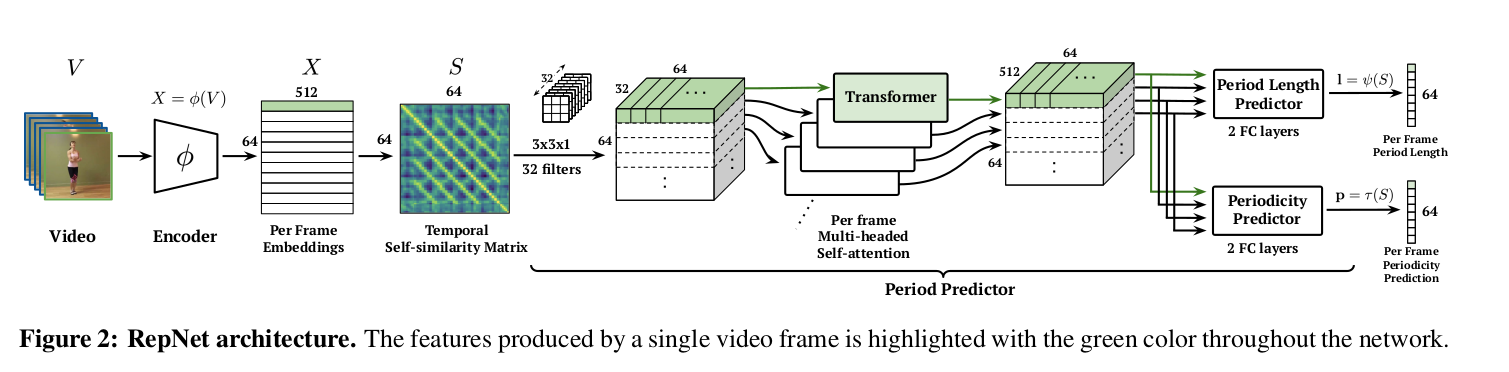

In [15]:
show_image('repnet_model.png', width=1000)

### Encoder

#### Convolutional Feature Extractor

In [16]:
class ResNet50Base5D(nn.Module):
    def __init__(self, pretrained=False, m=2):
        super().__init__()
        base_model = M.resnet50(pretrained=pretrained)
        
        if m == 1:
            # method-1:
            base_model.fc = nn.Identity()
            base_model.avgpool = nn.Identity()
            base_model.layer4 = nn.Identity()
            base_model.layer3[3] = nn.Identity()
            base_model.layer3[4] = nn.Identity()
            base_model.layer3[5] = nn.Identity()
            self.base_model = base_model
        else:
            # method-2:
            self.base_model = nn.Sequential(
                *list(base_model.children())[:-4],
                *list(base_model.children())[-4][:3])
 
    def forward(self, x):
        N, S, C, H, W = x.shape 
        x = x.view(-1, C, H, W) # 5D -> 4D
        x = self.base_model(x)
        x = x.view(N, S, x.shape[1], x.shape[2], x.shape[3]) # 4D -> 5D
        return x

In [17]:
resnet50 = ResNet50Base5D(pretrained=True, m=2)
resnet50

ResNet50Base5D(
  (base_model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): C

In [18]:
resnet50_outputs = resnet50(X)
resnet50_outputs.shape

torch.Size([4, 64, 1024, 7, 7])

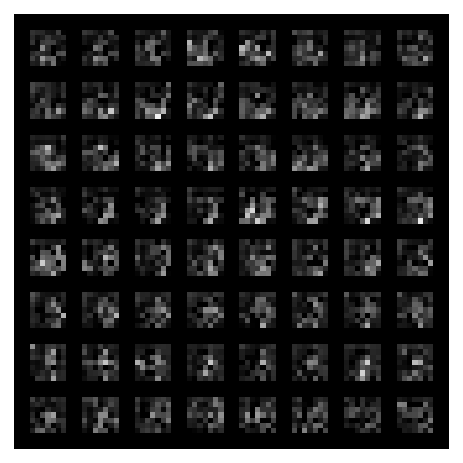

In [19]:
g = resnet50_outputs[0][:, :1]
g = make_grid(g, padding=3)
g = g.detach().numpy().transpose((1, 2, 0))
plt.axis('off')
plt.imshow(g, plt.get_cmap('gray'))

#### Temporal Context

In [20]:
class TemporalContext(nn.Module):
    def __init__(self, in_channels=1024, out_channels=512):
        super().__init__()
        self.conv3D = nn.Sequential(
            nn.Conv3d(
                in_channels = in_channels,
                out_channels = out_channels,
                kernel_size = 3,
                padding = (3, 1, 1),
                dilation = (3, 1, 1)),
            nn.BatchNorm3d(out_channels),
            nn.ReLU())
        
    def forward(self, x):
        # (N, S, C, H, W) -> (N, C, S, H, W)
        x = x.transpose(1, 2)
        x = self.conv3D(x)
        return x

In [21]:
TC = TemporalContext()
TC

TemporalContext(
  (conv3D): Sequential(
    (0): Conv3d(1024, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(3, 1, 1), dilation=(3, 1, 1))
    (1): BatchNorm3d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
)

In [22]:
tc_outputs = TC(resnet50_outputs)
tc_outputs.shape

torch.Size([4, 512, 64, 7, 7])

#### Dimensionality Reduction

In [23]:
class GlobalMaxPool(nn.Module):
    def __init__(self, m=2):
        super().__init__()
        self.m = m
        
        # method:2
        self.pool = nn.MaxPool3d(kernel_size = (1, 7, 7))
        
    def forward(self, x):
        # Inputs: (N, C, S, 7, 7)
        # method:1
        if self.m == 1:
            x, _ = torch.max(x, dim=4)
            x, _ = torch.max(x, dim=3)
        else:
            # method:2
            x = self.pool(x).squeeze(-1).squeeze(-1)
        
        x = x.transpose(1, 2)
        return x # (N, S, C)

In [24]:
GMP = GlobalMaxPool(m=2)
gmp_outputs = GMP(tc_outputs)
gmp_outputs.shape

torch.Size([4, 64, 512])

### Temporal Self-similarity Matrix(TSM)

In [25]:
class TemproalSelfMatrix(nn.Module):
    def __init__(self, temperature=13.544, m=2):
        super().__init__()
        self.temperature = temperature
        self.m = m
        
    def calc_sims(self, x):
        # (N, S, E)  --> (N, 1, S, S)
        S = x.shape[1]
        
        I = torch.ones(S).to(x.device)
        xr = torch.einsum('nse,h->nhse', (x, I))
        xc = torch.einsum('nse,h->nshe', (x, I))
        diff = xr - xc
        return torch.einsum('nsge,nsge->nsg', (diff, diff))
        
    def pairwise_l2_distance(self, x):
        # (S, E)
        a, b = x, x
        norm_a = torch.sum(torch.square(a), dim=1)
        norm_a = torch.reshape(norm_a, [-1, 1])
        norm_b = torch.sum(torch.square(b), dim=1)
        norm_b = torch.reshape(norm_b, [1, -1])
        b = torch.transpose(b, 0, 1)  # a: 64x512  b: 512x64
        dist = torch.maximum(norm_a - 2.0 * torch.matmul(a, b) + norm_b,
                             torch.tensor(0.0, device=x.device))
        return dist
    
    def forward(self, x):
        # x: (N, S, E)
        # method: 1
        if self.m == 1:
            # x = torch.transpose(x, 1, 2)
            sims_list = []
            for i in range(x.shape[0]):
                sims_list.append(self.pairwise_l2_distance(x[i]))
            sims = torch.stack(sims_list)
        else:
            # method: 2
            sims = self.calc_sims(x)
        
        sims = F.softmax(-sims/self.temperature, dim=-1)
        sims = sims.unsqueeze(1)
        return F.relu(sims) # (N, 1, S, S)

In [26]:
TSM = TemproalSelfMatrix(m=2)
tsm_outputs = TSM(gmp_outputs)
tsm_outputs.shape, tsm_outputs

(torch.Size([4, 1, 64, 64]),
 tensor([[[[9.9868e-01, 1.0559e-03, 2.6522e-04,  ..., 8.9985e-12,
            9.0676e-13, 1.0422e-11],
           [1.0549e-03, 9.9770e-01, 1.2486e-03,  ..., 1.2252e-11,
            1.9515e-12, 8.7108e-12],
           [2.6516e-04, 1.2496e-03, 9.9849e-01,  ..., 6.3270e-12,
            7.9931e-13, 3.4186e-12],
           ...,
           [9.0093e-12, 1.2279e-11, 6.3359e-12,  ..., 9.9988e-01,
            1.0283e-04, 1.6003e-05],
           [9.0783e-13, 1.9557e-12, 8.0041e-13,  ..., 1.0282e-04,
            9.9986e-01, 3.5610e-05],
           [1.0435e-11, 8.7304e-12, 3.4236e-12,  ..., 1.6004e-05,
            3.5613e-05, 9.9995e-01]]],
 
 
         [[[9.4417e-01, 4.4571e-02, 1.1262e-02,  ..., 2.8797e-12,
            2.1212e-12, 1.0801e-11],
           [4.4955e-02, 9.5230e-01, 2.7461e-03,  ..., 8.9403e-12,
            1.1038e-11, 2.5293e-11],
           [1.1754e-02, 2.8416e-03, 9.8540e-01,  ..., 3.3644e-12,
            3.6329e-12, 1.0582e-11],
           ...,
      

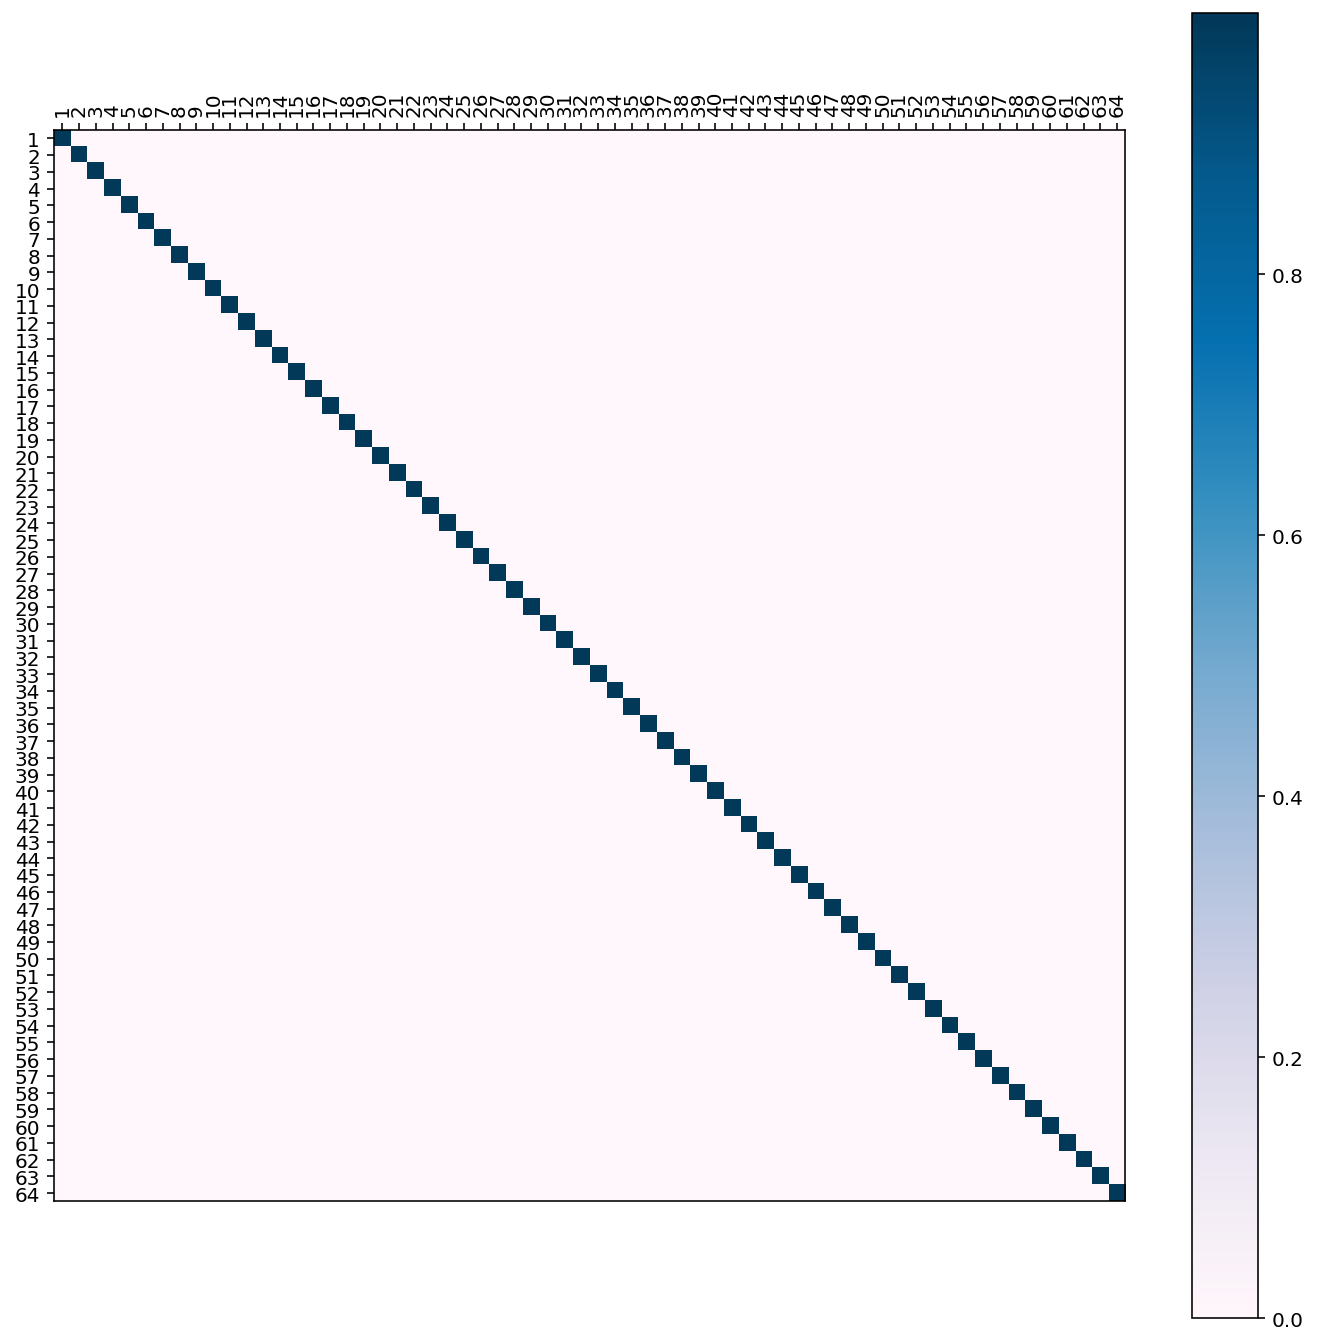

In [27]:
def show_hotmap(data):
    fig = plt.figure(figsize=(12, 12))
    
    xlabel = range(1, data.shape[0] + 1)
    ylabel = range(1, data.shape[0] + 1)
    ax = fig.add_subplot(111)
    
    ax.set_xticks(range(len(xlabel)))
    ax.set_xticklabels(xlabel, rotation=90)
    ax.xaxis.set_ticks_position('top') 
    
    ax.set_yticks(range(len(ylabel)))
    ax.set_yticklabels(ylabel)
    
    im = ax.imshow(data, cmap=plt.cm.PuBu)
    plt.colorbar(im)
tsm_hotmap_data = tsm_outputs[0][0].detach().numpy()
show_hotmap(tsm_hotmap_data)

### Period Predictor

#### Features Projection

In [28]:
class FeaturesProjection(nn.Module):
    def __init__(self, num_frames=64, out_features=512, dropout=0.2):
        super().__init__()
        self.num_frames = num_frames
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=1,
                      out_channels=32,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(p=dropout))
        self.projection = nn.Sequential(
            nn.Linear(num_frames*32, out_features),
            nn.ReLU(),
            nn.LayerNorm(out_features))

    def forward(self, x):
        x = self.features(x) # N, 32, S, S
        x = x.permute(0, 2, 3, 1)
        x = x.reshape(x.size(0), self.num_frames, -1) # N, S, 32*S
        x = self.projection(x) # N, S, 512
        return x

In [29]:
FPL = FeaturesProjection()
fpl_outputs = FPL(tsm_outputs)
fpl_outputs.shape

torch.Size([4, 64, 512])

#### Transformer Encoder

In [30]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1) # S, 1, d_model
        self.register_buffer('pe', pe)


    def forward(self, x):
        # (S, N, 512)
        x = x + self.pe[:x.size(0), :, :]
        return self.dropout(x)
    
class TransformerModel(nn.Module):
    def __init__(self, num_frames=64, d_model=512, 
                 n_head=4, dim_ff=512, dropout=0.2,
                 num_layers=2, m=2):
        super().__init__()
        self.m = m
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_head,
            dim_feedforward=dim_ff,
            dropout=dropout,
            activation='relu')
        encoder_norm = nn.LayerNorm(d_model)
        if m == 1:
            self.pos_encoder = PositionalEncoding(d_model, dropout, num_frames)
        else:
            self.pos_encoder = torch.empty(1, num_frames, 1).normal_(mean=0, std=0.02)
            self.pos_encoder.requires_grad = True

        self.trans_encoder = nn.TransformerEncoder(encoder_layer, num_layers, encoder_norm)
                
    def forward(self, x):
        if self.m == 1:
            x = x.transpose(0, 1)
            x = self.pos_encoder(x) # S, N, D_Model
            x = self.trans_encoder(x)
            x = x.transpose(0, 1)
        else:
            x += self.pos_encoder # S, N, D_Model
            x = self.trans_encoder(x)
        return x

In [31]:
TE = TransformerModel(NUM_FRAMES, d_model=NUM_DMODEL, n_head=4, dropout=0.2, dim_ff=512, m=2)
te_outputs = TE(fpl_outputs)
te_outputs.shape

torch.Size([4, 64, 512])

#### Period Classifier

In [32]:
class PeriodClassifier(nn.Module):
    def __init__(self, num_frames=64, in_features=512):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=num_frames//2),
            nn.ReLU(),
            nn.Linear(in_features=num_frames//2, out_features=1),
            nn.ReLU())
        
    def forward(self, x):
        x = self.classifier(x)
        return x

In [33]:
pc = PeriodClassifier(NUM_FRAMES)
pc_outputs = pc(te_outputs)
pc_outputs.shape

torch.Size([4, 64, 1])

### Make All Together

In [34]:
class RepNet(nn.Module):
    def __init__(self, num_frames=64, num_dmodel=512):
        super().__init__()
        ## Encoder
        self.resnet50 = ResNet50Base5D(pretrained=True)
        self.tcxt = TemporalContext()
        self.maxpool = GlobalMaxPool(m=2)
        ## TSM
        self.tsm = TemproalSelfMatrix(temperature=13.544, m=2)
        ## Period Predictor
        self.projection = FeaturesProjection(num_frames=num_frames, out_features=num_dmodel, dropout=0.2)
        ### period length prediction
        self.trans1 = TransformerModel(num_frames, d_model=num_dmodel, n_head=4,
                                   dropout=0.2, dim_ff=num_dmodel)
        self.pc1 = PeriodClassifier(num_frames, num_dmodel)
        ### periodicity prediction
        self.trans2 = TransformerModel(num_frames, d_model=num_dmodel, n_head=4,
                                   dropout=0.2, dim_ff=num_dmodel)
        self.pc2 = PeriodClassifier(num_frames, num_dmodel)
        
    def forward(self, x, retsim=False):
        x = self.resnet50(x)
        x = self.tcxt(x)
        x = self.maxpool(x)
        x = self.tsm(x)
        if retsim:
            z = x
        x = self.projection(x)
        
        y1 = self.pc1(self.trans1(x))
        y2 = self.pc2(self.trans2(x))
        if retsim:
            return y1, y2, z
        else:
            return y1, y2

In [35]:
repnet = RepNet()
y1, y2 = repnet(X)
y1.shape, y2.shape

(torch.Size([4, 64, 1]), torch.Size([4, 64, 1]))

In [36]:
# for name, params in repnet.named_parameters():
#     if name == "resnet50.base_model.0.weight":
#         print(params[0])

## Train

In [37]:
train_dataset = CountixDataset(DATASET_PREFIX, 'train')
train_loader = DataLoader(train_dataset, batch_size=10, num_workers=4, shuffle=True, drop_last=True)

valid_dataset = CountixDataset(DATASET_PREFIX, 'val')
valid_loader = DataLoader(valid_dataset, batch_size=10, num_workers=4, shuffle=False)

test_dataset = CountixDataset(DATASET_PREFIX, 'test')
test_loader = DataLoader(valid_dataset, batch_size=4, num_workers=1, shuffle=False)

In [38]:
ckpt_path = f'{DATASET_PREFIX}/repnet3.pt'
device = torch.device("cuda")
model = RepNet(NUM_FRAMES, NUM_DMODEL)

optimizer = O.Adam(model.parameters(), lr=0.0001)
# optimizer = O.SGD(model.parameters(), lr=lr)
# scheduler = O.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.9)
# scheduler = O.lr_scheduler.StepLR(optimizer=optimizer, step_size=5, gamma=0.9)
# scheduler = O.lr_scheduler.MultiStepLR(optimizer, milestones=[
#         3, 10, 50, 100, 200, 300, 400], gamma=0.6)
scheduler = O.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.06, patience=6, min_lr=1e-6)
criterions = [nn.SmoothL1Loss(), nn.BCEWithLogitsLoss()]

In [39]:
def train(device, model, pbar, optimizer, criterions, metrics_callback=None):
    model.train()
    loss_list = []
    for X, y1, y2, y3 in pbar:
        X, y1, y2 = X.to(device), y1.to(device), y2.to(device)

        y1_pred, y2_pred = model(X)

        loss1 = criterions[0](y1_pred, y1) 
        loss2 = criterions[1](y2_pred, y2)
        
        y3_pred = torch.sum((y2_pred > 0) / (y1_pred + 1e-1), 1)
        y3_calc = torch.sum((y2 > 0) / (y1 + 1e-1), 1)
        loss3 = criterions[0](y3_pred, y3_calc)

        loss = loss1 + 5*loss2 + loss3

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())

        if metrics_callback is not None:
            metrics_callback(
                '%.6f' % np.mean(loss_list),
                '%.6f' % loss1.item(),
                '%.6f' % loss2.item(),
                '%.6f' % loss3.item())
            
        del X, y1, y2, y1_pred, y2_pred
    return np.mean(loss_list)


def valid(device, model, pbar, criterions, metrics_callback=None):
    model.eval()
    loss_list = []
    with torch.no_grad():
        for X, y1, y2, _ in pbar:
            X, y1, y2 = X.to(device), y1.to(device), y2.to(device)
            y1_pred, y2_pred = model(X)

            loss1 = criterions[0](y1_pred, y1) 
            loss2 = criterions[1](y2_pred, y2)
            
            y3_pred = torch.sum((y2_pred > 0) / (y1_pred + 1e-1), 1)
            y3_calc = torch.sum((y2 > 0) / (y1 + 1e-1), 1)
            loss3 = criterions[0](y3_pred, y3_calc)
            
            loss = loss1 + 5*loss2 + loss3
            loss_list.append(loss.item())

            if metrics_callback is not None:
                metrics_callback(
                    '%.6f' % np.mean(loss_list),
                    '%.6f' % loss1.item(),
                    '%.6f' % loss2.item(),
                    '%.6f' % loss3.item())

            del X, y1, y2, y1_pred, y2_pred
    return np.mean(loss_list)


def inference(device, model, pbar, metrics_callback=None):
    model.eval()
    with torch.no_grad():
        for X, y1, y2, y3_true in pbar:
            X, y1, y2 = X.to(device), y1.to(device), y2.to(device)
            y1_pred, y2_pred = model(X)

            y3_pred = torch.round(torch.sum((y2_pred > 0) / (y1_pred + 1e-1), 1))
            y3_calc = torch.round(torch.sum((y2 > 0) / (y1 + 1e-1), 1))

            if metrics_callback is not None:
                metrics_callback(
                    y3_pred.cpu().numpy().flatten().astype(int).tolist()[:5],
                    y3_calc.cpu().numpy().flatten().astype(int).tolist()[:5],
                    y3_true.numpy().flatten().astype(int).tolist()[:5])
            # TODO only one test
            break


def train_loop(num_epochs, model, ckpt_path,
               train_loader, valid_loader,
               optimizer, scheduler, criterions, device):
    
    metrics_writer = open(f'{DATASET_PREFIX}/metrics.json', 'w')
    start_epoch = 0
    
    # load model
    if ckpt_path and os.path.exists(ckpt_path):
        checkpoint = torch.load(ckpt_path)
        model.load_state_dict(checkpoint['model_state_dict'], strict=True)
        start_epoch = checkpoint['epoch']
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        for state in optimizer.state.values():
            for k, v in state.items():
                if isinstance(v, torch.Tensor):
                    state[k] = v.to(device)
    
    lr = optimizer.param_groups[0]['lr']

    model = model.to(device)
    for epoch in tqdm(range(start_epoch, num_epochs + start_epoch)):
        # train
        torch.cuda.empty_cache()
        with tqdm(train_loader, file=metrics_writer, total=len(train_loader), desc='train') as pbar:
            train_loss = train(device, model, pbar, optimizer, criterions,
                               lambda loss, loss1, loss2, loss3: pbar.set_postfix(
                                   epoch=epoch, lr=lr, loss=loss, loss1=loss1, loss2=loss2, loss3=loss3))
            
            metrics_writer.write('Train: {}\n'.format(pbar))
            
        # valid
        torch.cuda.empty_cache()
        with tqdm(valid_loader, desc='valid') as pbar:
            valid_loss = valid(device, model, pbar, criterions,
                               lambda loss, loss1, loss2, loss3: pbar.set_postfix(
                                   epoch=epoch, lr=lr, loss=loss, loss1=loss1, loss2=loss2, loss3=loss3))
            metrics_writer.write('Valid: {}\n'.format(pbar))

            
        # inference
        torch.cuda.empty_cache()
        with tqdm(test_loader, desc='Inference') as pbar:
            inference(device, model, pbar,
                      lambda y_pred, y_calc, y_true: pbar.set_postfix(
                          y_pred=y_pred, y_calc=y_calc, y_true=y_true))
            metrics_writer.write('Inference: {}\n'.format(pbar))
                
        # update learning rate
        if isinstance(scheduler, O.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(train_loss) # todo
            lr = '%.8f' % scheduler._last_lr[0]
        else:
            scheduler.step()
            lr = '%.8f' % scheduler.get_last_lr()[0]
        
            
        metrics_writer.flush()
        
        # save model
        if ckpt_path is not None:
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'valid_loss': valid_loss,
            }
            torch.save(checkpoint, ckpt_path)
    
# train_loop(10, model, ckpt_path, \
#            train_loader, valid_loader, \
#            optimizer, scheduler, criterions, device)

## References

1. https://arxiv.org/pdf/2006.15418.pdf

2. https://colab.research.google.com/github/google-research/google-research/blob/master/repnet/repnet_colab.ipynb#scrollTo=76L5XFonl_Bw

## Other

In [43]:
import re

fm_int = '[-+]?\d+'
fm_float = '[-+]?[0-9]+\.[0-9]+'

train_mdata_list = []
valid_mdata_list = []

def parse_log(mdata_list, phase, log):
    resdata = re.search(
        r'%s: .*, epoch=(?P<epoch>%s), loss=(?P<loss>%s), loss1=(?P<loss1>%s), loss2=(?P<loss2>%s), loss3=(?P<loss3>%s), lr=(?P<lr>.*[^\]])'
        % (phase, fm_int, fm_float, fm_float, fm_float, fm_float), log)

    if resdata:
        grpdata = resdata.groupdict()
        mdata_list.append({
            'epoch': int(grpdata['epoch']),
            'loss': float(grpdata['loss']),
            'loss1': float(grpdata['loss1']),
            'loss2': float(grpdata['loss2']),
            'loss3': float(grpdata['loss3']),
            'lr': float(grpdata['lr'])
        })

with open('/data/metrics4.txt') as fr:
    for line in fr.read().split('\n'):
        parse_log(train_mdata_list, 'train', line)
        parse_log(valid_mdata_list, 'valid', line)
        
fig = go.Figure()

fig.add_trace(go.Scatter(
    x = [x['epoch'] for x in train_mdata_list],
    y = [x['loss'] for x in train_mdata_list],
    mode = 'lines',
    name = 'train loss'
))

fig.add_trace(go.Scatter(
    x = [x['epoch'] for x in valid_mdata_list],
    y = [x['loss'] for x in valid_mdata_list],
    mode = 'lines',
    name = 'valid loss'
))

In [41]:
df_train = pd.DataFrame(train_mdata_list)
df_train

,epoch,loss,loss1,loss2,loss3,lr
0,0,7.562,10.230,0.140,9.892,0.0001
1,1,3.910,6.534,0.133,8.761,0.0001
2,2,3.512,10.914,0.135,7.841,0.0001
3,3,3.155,11.116,0.136,6.918,0.0001
4,4,2.955,8.695,0.127,4.755,0.0001
5,5,2.684,7.061,0.116,5.382,0.0001
6,6,2.600,6.124,0.127,3.928,0.0001
7,7,2.437,11.054,0.131,5.412,0.0001
8,8,2.373,6.106,0.097,2.118,0.0001
9,9,2.396,6.268,0.141,9.505,0.0001


In [42]:
df = pd.DataFrame(valid_mdata_list)
df

,epoch,loss,loss1,loss2,loss3,lr
0,0,4.390,13.633,0.141,12.616,0.0001
1,1,3.798,13.141,0.134,9.727,0.0001
2,2,3.505,12.659,0.134,8.255,0.0001
3,3,3.231,12.161,0.130,6.670,0.0001
4,4,2.984,11.674,0.128,5.278,0.0001
5,5,2.851,11.199,0.128,4.564,0.0001
6,6,2.699,10.749,0.125,3.716,0.0001
7,7,2.577,10.318,0.126,3.067,0.0001
8,8,2.525,9.920,0.140,2.843,0.0001
9,9,2.458,9.550,0.131,2.357,0.0001


```
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(*list(models.resnet50(pretrained=True).children())[:-3])
        self.temporal_context = nn.Sequential(nn.Conv3d(in_channels=1024,
                                out_channels=512,kernel_size=3,padding=[1,0,0]), nn.ReLU())
   

    def forward(self,x):
        b, f, c, h, w = x.size()
        features = self.cnn(x.view(b*f, c, h, w))
        temp_features = self.temporal_context(features.unsqueeze(0).view(b,features.shape[1], f,features.shape[2],features.shape[3]))
        out = nn.AvgPool2d(5)(temp_features.view(b*f,512, temp_features.shape[-1], temp_features.shape[-1])).view(b, f, -1)
        return out

class PeriodPredictor(nn.Module):

    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3), nn.ReLU())
        self.projection = nn.Linear(1922,512)
        self.transformer = nn.Transformer(nhead=4,dim_feedforward=128)

    def forward(self, x):
        out = self.cnn(x)
        out = out.view(x.size(0), 64, -1)
        out = self.projection(out)
        out = self.transformer(out, out)
        return out

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.l_network = nn.Sequential(nn.Linear(512,512),nn.ReLU(),nn.Linear(512,32))
        self.p_network = nn.Sequential(nn.Linear(512,512),nn.ReLU(),nn.Linear(512,1))

    def forward(self, x):
        b, f, e = x.size()
        l = self.l_network(x.view(b*f,-1))
        p = self.p_network(x.view(b*f,-1))
        return l.view(b,-1), p.view(b,-1)

class RepNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.period_predictor = PeriodPredictor()
        self.classifier = Classifier()
        self.optimizer = torch.optim.SGD(params=self.parameters(),  lr=1e-3, momentum=0.9, weight_decay=5e-4)

    def forward(self, x):
        features = self.encoder(x)
        sim_mat = -torch.matrix_power(torch.cdist(features, features), 2).unsqueeze(1)
        period = self.period_predictor(sim_mat)
        l, p = self.classifier(period)
        return l, p

    def train_epoch(self, loader, epoch, device):
        self.train()
        print(
            "\n" + " " * 10 + "****** Epoch {epoch} ******\n"
            .format(epoch=epoch)
        )

        training_losses = []
        mae = deque(maxlen=30)
        self.optimizer.zero_grad()
        with tqdm(total=len(loader), ncols=80) as pb:


            for batch_idx, d in enumerate(loader):
                frames, l, p = d
                frames, l, p = frames.to(device), l.to(device), p.to(device)
                frames.requires_grad = True
                self.optimizer.zero_grad()
                l_logits, p_logits = self.forward(frames)
                loss = torch.nn.BCELoss()(torch.nn.Sigmoid()(p_logits.view(-1)),p.float().view(-1))
                loss += torch.nn.CrossEntropyLoss()(l_logits.view(frames.shape[0]*64,32), l.view(-1))
                training_losses.append(loss.data.cpu().numpy())
                loss.backward()
                clip_gradient(self.optimizer, 0.1)
                self.optimizer.step()
                counts_t = []
                counts_p = []
                p_preds = torch.where(torch.nn.Sigmoid()(p_logits) > 0.5, torch.tensor(1).cuda(), torch.tensor(0).cuda())
                l_preds = l_logits.view(frames.shape[0],64,32).argmax(2)
                for l_i, p_i, ll_i, pl_i in zip(l, p, l_preds, p_preds):
                    reps = torch.where(l_i>0)[0]
                    counts_t.append( torch.sum(torch.div(p_i[reps].float(),l_i[reps].float())).data.cpu().numpy())
                    counts_p.append( torch.sum(torch.div(pl_i[reps].float(),ll_i[reps].float())).data.cpu().numpy())
                try:
                    mae_i = mean_absolute_error(np.array(counts_t), np.array(counts_p))
                    mae.append(mae_i)
                    pb.update()
                    pb.set_description(
                        f"Loss: {loss.item()}, MAE: {np.mean(mae)}")

                except Exception as e:
                    print(e)
                    continue


    def validate(self, loader):
        self.eval()
        with tqdm(total=len(loader), ncols=80) as pb:
            for batch_idx, frames, l, p in enumerate(loader):
                l_logits, p_logits = self.forward(frames)
                loss = torch.nn.CrossEntropyLoss()(l_logits, l) + torch.nn.CrossEntropyLoss()(p_logits, p)
                pb.update()
                pb.set_description(
                    "Loss: {:.4f}".format(
                        loss.item()))```
```